In [1]:
import pandas_gbq
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import statsmodels.api as sm
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib widget
import numpyro
import numpyro.distributions as dist
from numpyro.primitives import deterministic
from numpyro.infer import MCMC, NUTS
import arviz
import jax
from scipy.stats import norm, invgamma

# Read Data from CSV

In [2]:
df = pd.read_csv('euribor_rates.csv')
df['date'] =  pd.to_datetime(df['date'])
df = df.reset_index(drop = True)

print("Shape of the data frame: " + str(df.shape))
display(df)
print(df.info())

Shape of the data frame: (24968, 3)


,date,rate,value
0,2023-04-25,euribor_1_month,3.024
1,2023-04-25,euribor_3_month,3.268
2,2023-04-25,euribor_6_month,3.635
3,2023-04-25,euribor_12_month,3.900
4,2023-04-24,euribor_1_month,3.031
...,...,...,...
24963,1999-01-05,euribor_12_month,3.187
24964,1999-01-04,euribor_1_month,3.242
24965,1999-01-04,euribor_3_month,3.234
24966,1999-01-04,euribor_6_month,3.223


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24968 entries, 0 to 24967
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    24968 non-null  datetime64[ns]
 1   rate    24968 non-null  object        
 2   value   24968 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 585.3+ KB
None


# Define seperated columns for each rate

In [3]:
euribor_12 = df.loc[df['rate'] == 'euribor_12_month', ['date', 'value']].rename(columns = {'value':'euribor_12_month'})
euribor_6 = df.loc[df['rate'] == 'euribor_6_month', ['date', 'value']].rename(columns = {'value':'euribor_6_month'})
euribor_3 = df.loc[df['rate'] == 'euribor_3_month', ['date', 'value']].rename(columns = {'value':'euribor_3_month'})
euribor_1 = df.loc[df['rate'] == 'euribor_1_month', ['date', 'value']].rename(columns = {'value':'euribor_1_month'})

df = pd.merge(euribor_12, euribor_6, how="inner", left_on='date', right_on='date')
df = pd.merge(df, euribor_3, how="inner", left_on='date', right_on='date')
df = pd.merge(df, euribor_1, how="inner", left_on='date', right_on='date')

df = df.set_index('date')
df = df.resample('D')
df = df.ffill()

display(df)
display(df.info())

,euribor_12_month,euribor_6_month,euribor_3_month,euribor_1_month
date,,,,
1999-01-04,3.209,3.223,3.234,3.242
1999-01-05,3.187,3.204,3.222,3.233
1999-01-06,3.176,3.197,3.214,3.226
1999-01-07,3.158,3.179,3.206,3.224
1999-01-08,3.139,3.166,3.196,3.217
...,...,...,...,...
2023-04-21,3.854,3.601,3.261,2.956
2023-04-22,3.854,3.601,3.261,2.956
2023-04-23,3.854,3.601,3.261,2.956


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8878 entries, 1999-01-04 to 2023-04-25
Freq: D
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   euribor_12_month  8878 non-null   float64
 1   euribor_6_month   8878 non-null   float64
 2   euribor_3_month   8878 non-null   float64
 3   euribor_1_month   8878 non-null   float64
dtypes: float64(4)
memory usage: 346.8 KB


None

# Plot historical Euribor rates

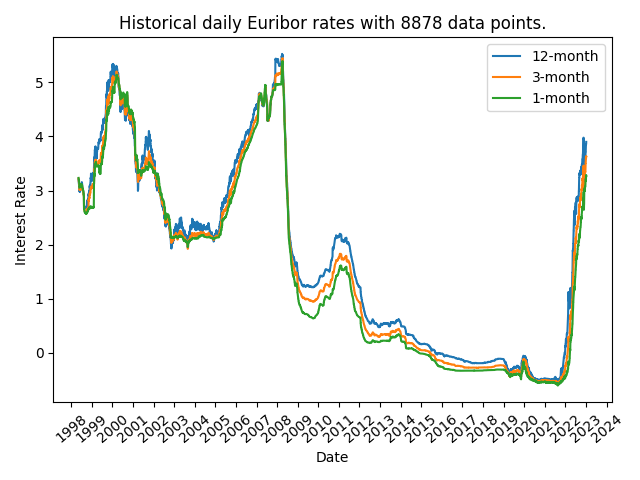

In [4]:
plt.figure(1)
plt.clf()

plt.plot(df['euribor_12_month'], label='12-month')
plt.plot(df['euribor_6_month'], label='3-month')
plt.plot(df['euribor_3_month'], label='1-month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=360))
plt.gca().xaxis.set_tick_params(rotation = 40) 

plt.legend()
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.title(f'Historical daily Euribor rates with {len(df)} data points.')
plt.tight_layout()

plt.show()

# Backtesting

In [5]:
def monthly_payment_annuety(N, r, T):
    '''
    N loan amoun, r interest rate, T loan maturity in years
    '''
    if r <= 0: r = 0.01
    return ((1 + r/12 / 100)**(T*12) * (r/12 / 100)) / ((1 + r/12 / 100)**(T*12) - 1) * N


def backtesting(rate_type, N, T):
    '''
    rate_type euribor [int], N loan amoun, T loan maturity in years
    '''
    if rate_type == 12:  period = 360; rate_col = 0
    elif rate_type == 6: period = 180; rate_col = 1
    elif rate_type == 3: period = 90;  rate_col = 2
    elif rate_type == 1: period = 30;  rate_col = 3
    else:
        raise ValueError('Invalid rate type')

    payments_list = []
    total_payments_list = []
    origination_date_list = []
    dates_list = []
    maturity_days = T*360
    for i in range(len(df)):
        if i+maturity_days >= len(df):
            break

        indexes = np.arange(i, i+maturity_days-1, period)
        rates = df.iloc[indexes, rate_col]
        indexes = np.arange(i, i+maturity_days-1, 30)
        dates = df.iloc[indexes].index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
        dates = dates.values.astype('datetime64[D]').tolist()
        dates_list += dates
        origination_date_list.append(df.index.values[i])
        payments = 0

        for j, rate in enumerate(rates):
            payment = monthly_payment_annuety(N, rate, T)
            payments += payment*rate_type
            payments_list += [payment]*rate_type
        total_payments_list.append(payments)

    return total_payments_list, origination_date_list, payments_list, dates_list

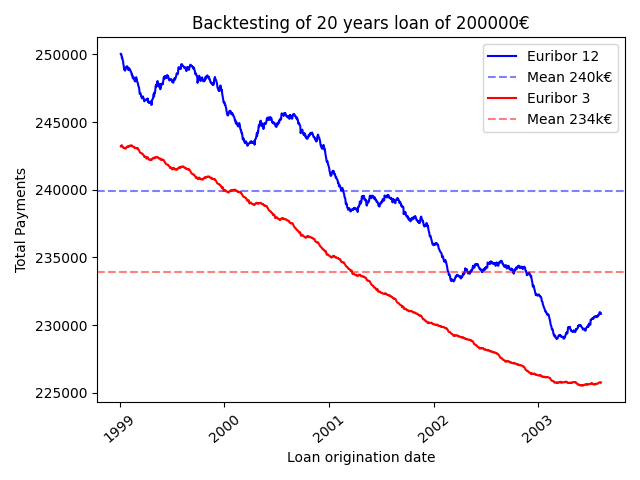

In [6]:
maturity = 20
loan_amount = 200000

plt.figure(2)

toal_payments, origination_dates, payments, dates = backtesting(12, loan_amount, maturity)
plt.plot(origination_dates, toal_payments, color='blue', label='Euribor 12')
plt.axhline(np.mean(toal_payments), c='blue', linestyle='--', alpha=0.5, label=f'Mean {np.mean(toal_payments)/1000:.0f}k€')

toal_payments, origination_dates, payments, dates = backtesting(3, loan_amount, maturity)
plt.plot(origination_dates, toal_payments, color='red', label='Euribor 3')
plt.axhline(np.mean(toal_payments), c='red', linestyle='--', alpha=0.5, label=f'Mean {np.mean(toal_payments)/1000:.0f}k€')

plt.gca().xaxis.set_tick_params(rotation = 40) 
plt.legend()
plt.xlabel("Loan origination date")
plt.ylabel("Total Payments")
plt.title(f'Backtesting of {maturity} years loan of {loan_amount}€')
plt.tight_layout()
plt.show()

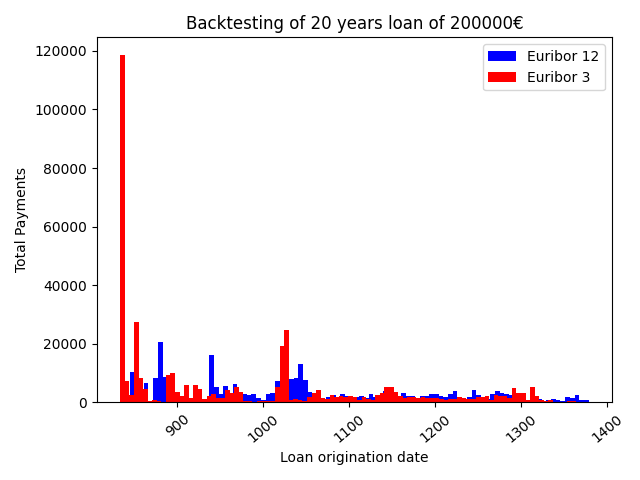

In [7]:
maturity = 20
loan_amount = 200000

plt.figure(3)

toal_payments, origination_dates, payments, dates = backtesting(12, loan_amount, maturity)
plt.hist(payments, 100, color='blue', label='Euribor 12')

toal_payments, origination_dates, payments, dates = backtesting(3, loan_amount, maturity)
plt.hist(payments, 100, color='red', label='Euribor 3')

plt.gca().xaxis.set_tick_params(rotation = 40) 
plt.legend()
plt.xlabel("Loan origination date")
plt.ylabel("Total Payments")
plt.title(f'Backtesting of {maturity} years loan of {loan_amount}€')
plt.tight_layout()
plt.show()

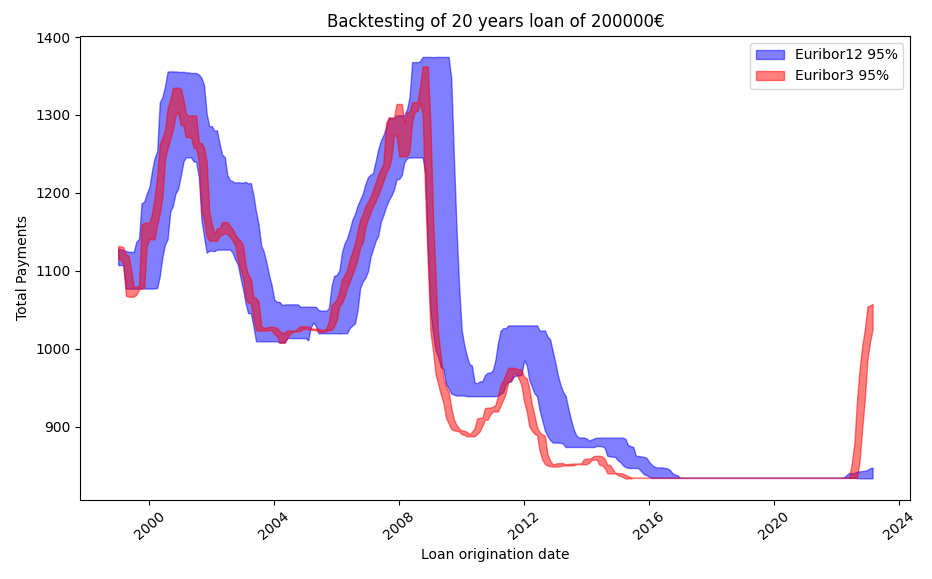

In [12]:
maturity = 20
loan_amount = 200000

plt.figure(4)
plt.clf()

# Euribor 12
toal_payments, origination_dates, payments, dates = backtesting(12, loan_amount, maturity)
plot_df = pd.DataFrame({'date': dates, 'payments': payments})
plot_df = plot_df.groupby(['date']).agg(median=('payments', 'median'), 
                                        lower_95=('payments', lambda x: np.quantile(x, q=0.025)), 
                                        upper_95=('payments', lambda x: np.quantile(x, q=0.975))).reset_index()

plt.fill_between(plot_df['date'], plot_df['lower_95'], y2=plot_df['upper_95'], color='blue', alpha=0.5, label='Euribor12 95%')
#plt.plot(plot_df['date'], plot_df['median'], color='blue', label='Euribor12 median')

# Euribor 3
toal_payments, origination_dates, payments, dates = backtesting(3, loan_amount, maturity)
plot_df = pd.DataFrame({'date': dates, 'payments': payments})
plot_df = plot_df.groupby(['date']).agg(median=('payments', 'median'), 
                                        lower_95=('payments', lambda x: np.quantile(x, q=0.025)), 
                                        upper_95=('payments', lambda x: np.quantile(x, q=0.975))).reset_index()

plt.fill_between(plot_df['date'], plot_df['lower_95'], y2=plot_df['upper_95'], color='red', alpha=0.5, label='Euribor3 95%')
#plt.plot(plot_df['date'], plot_df['median'], color='red', label='Euribor3 median')


plt.gca().xaxis.set_tick_params(rotation = 40) 
plt.legend()
plt.xlabel("Loan origination date")
plt.ylabel("Total Payments")
plt.title(f'Backtesting of {maturity} years loan of {loan_amount}€')
plt.tight_layout()
plt.show()

# Plot historical difference between 12 and 3-month Euribor rates

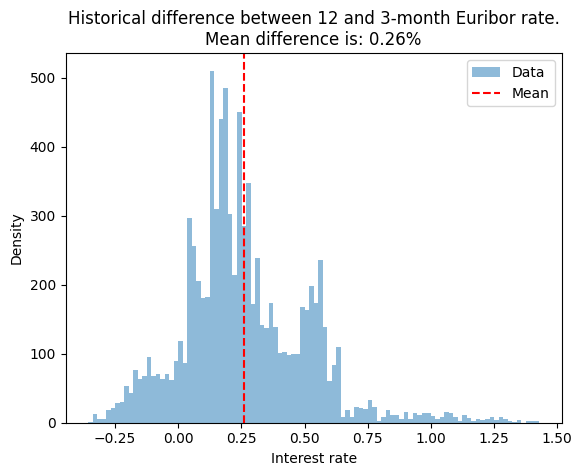

In [8]:

interest_diff = df['euribor_12_month'].values - df['euribor_3_month'].values

plt.hist(interest_diff , 100, alpha=0.5, label='Data')
plt.axvline(np.mean(interest_diff), c = 'red', linestyle = '--', label='Mean')

plt.legend()
plt.xlabel("Interest rate")
plt.ylabel("Density")
plt.title(f"Historical difference between 12 and 3-month Euribor rate.\nMean difference is: {np.mean(interest_diff):.2f}%")
plt.show()



# Sampple Posterior distribution using Markov Chain Monte Carlo (MCMC), with No U Turn Sampler (NUTS)

In [9]:
def model_normal():

    muu = numpyro.sample('muu', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.InverseGamma(1, 0.5))
    numpyro.sample('y_a', dist.Normal(muu, sigma), obs=interest_diff)
    poseterior_pred = numpyro.sample('poseterior_pred', dist.Normal(muu, sigma))

algo = NUTS(model_normal)
sampler = MCMC(algo, num_warmup = 1000, num_samples = 10000, num_chains = 1)
seed = jax.random.PRNGKey(0)
sampler.run(seed) 
sample = sampler.get_samples()
sampler.print_summary()

sample: 100%|██████████| 11000/11000 [00:06<00:00, 1608.09it/s, 7 steps of size 5.05e-01. acc. prob=0.95]



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
              muu      0.26      0.00      0.26      0.26      0.27  10562.09      1.00
  poseterior_pred      0.26      0.25      0.26     -0.16      0.66   7127.21      1.00
            sigma      0.25      0.00      0.25      0.25      0.25   7949.62      1.00

Number of divergences: 0


# Plot the Prior, Data and 500 samples from the Posterior

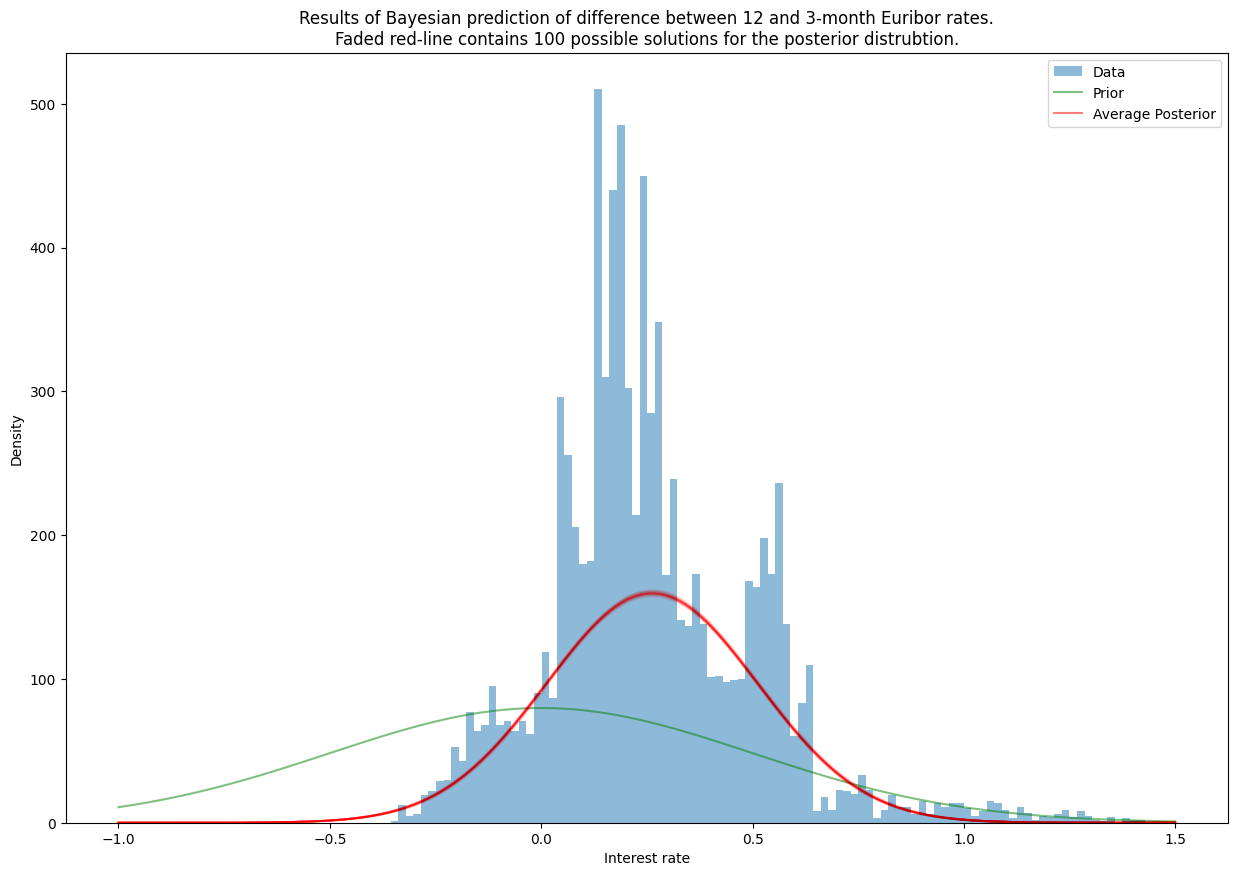

In [10]:
fig = plt.figure(figsize=(15, 10))
plt.hist(interest_diff, 100, alpha=0.5, label='Data') 
x = np.linspace(-1, 1.5, 400)
plt.plot(x, norm.pdf(x, 0, 0.5)*100, color='green', alpha=0.5, label='Prior')
plt.plot(x, norm.pdf(x, np.mean(sample['muu']), np.mean(sample['sigma']))*100, color='red', alpha=0.5, label='Average Posterior')
for i in range(1,100):
    plt.plot(x, norm.pdf(x, sample['muu'][i], sample['sigma'][i])*100, color='red', alpha=0.01)

plt.legend()
plt.xlabel("Interest rate")
plt.ylabel("Density")
plt.title("Results of Bayesian prediction of difference between 12 and 3-month Euribor rates.\nFaded red-line contains 100 possible solutions for the posterior distrubtion.")
plt.show()

# Analyse the distribution of the mean

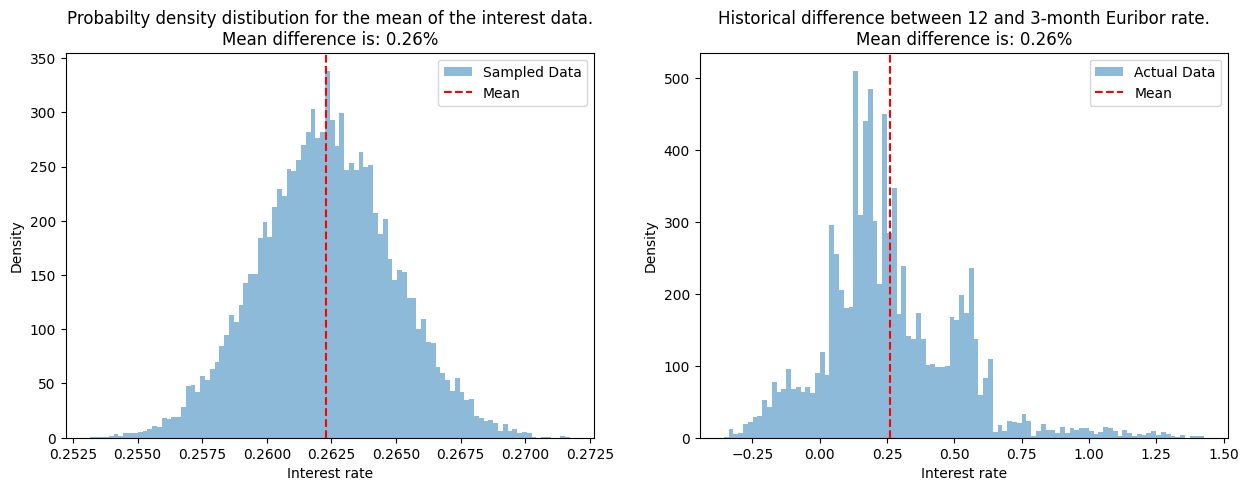

In [11]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.hist(sample['muu'] , 100, alpha=0.5, label='Sampled Data') 
plt.axvline(np.mean(sample['muu']), c = 'red', linestyle = '--', label='Mean')

plt.legend()
plt.xlabel("Interest rate")
plt.ylabel("Density")
plt.title(f"Probabilty density distibution for the mean of the interest data.\nMean difference is: {np.mean(sample['muu']):.2f}%")

plt.subplot(1, 2, 2)
plt.hist(interest_diff , 100, alpha=0.5, label='Actual Data') 
plt.axvline(np.mean(interest_diff), c = 'red', linestyle = '--', label='Mean')

plt.legend()
plt.xlabel("Interest rate")
plt.ylabel("Density")
plt.title(f"Historical difference between 12 and 3-month Euribor rate.\nMean difference is: {np.mean(interest_diff):.2f}%")


plt.show()

# Propability that difference is grater than...

Text(0.5, 1.0, 'Propability that interest rate difference is grater than 0.26% is 0.81%')

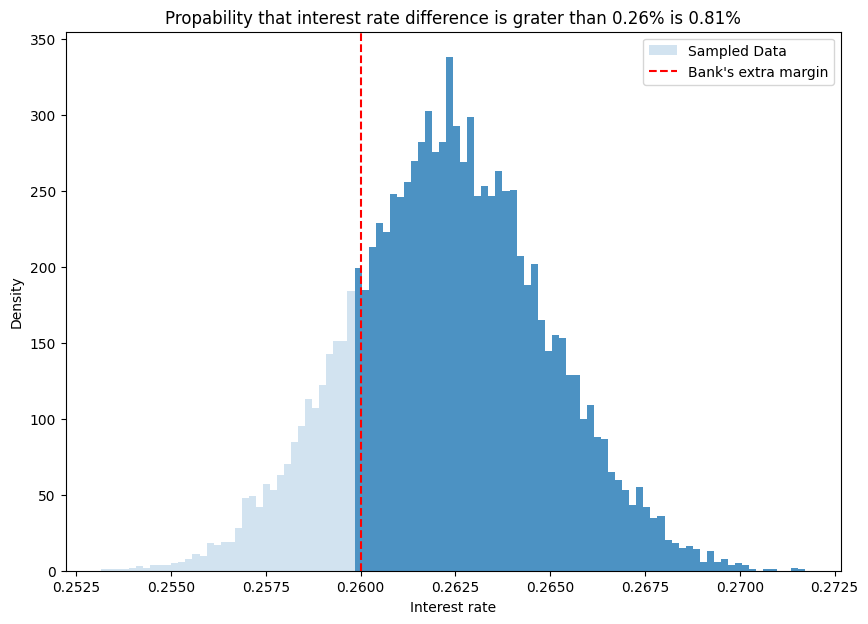

In [12]:
BANKS_EXTRA_INTERST_COST = 0.26

prob = sum(sample['muu'] > BANKS_EXTRA_INTERST_COST) / len(sample['muu'])

plt.figure(figsize = (10, 7))
n, bins, patches = plt.hist(sample['muu'] , 100, alpha=0.8, label='Sampled Data') 
for i in range(0, len(bins[bins<BANKS_EXTRA_INTERST_COST])-1):
    patches[i].set_alpha(0.2)
plt.axvline(BANKS_EXTRA_INTERST_COST, c = 'red', linestyle = '--', label="Bank's extra margin")

plt.legend()
plt.xlabel("Interest rate")
plt.ylabel("Density")
plt.title(f"Propability that interest rate difference is grater than {BANKS_EXTRA_INTERST_COST}% is {prob:.2f}%")